#### TODO:

~~Train&Test~~
- ~~split the dataset into train and test~~
- ~~drop the lables that are not working!~~

~~Inputs&Labels~~
- ~~mix the labels and input orders (all of them are [0,1])~~

Articles&Tenses
- Remove the articles and present tense verbs - Maunally :(

## Imports

In [198]:
import os
import requests
import pandas as pd
from PIL import Image
import io
import ast
import random
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from lambeq.backend.grammar import Ty, Box 
from lambeq import BobcatParser, AtomicType, Sim14Ansatz, RemoveCupsRewriter


print("(*) All libraries are successfully imported!\n")

(*) All libraries are successfully imported!



## Dataset

Split the dataset and label into trainign and testing similar to the pennyland model

In [199]:
# ==============================================
# ==============================================

# Read the CSV file
file_path = os.path.join(os.getcwd(), "features_dataset.csv")
df = pd.read_csv(file_path)

# Extract the sentence
sentence = df['sentence']
image_1 = df['image_1']
image_2 = df['image_2']
label_image1 = df['label_image1']
label_image2 = df['label_image2']

df = pd.DataFrame({
    'sentence': sentence,
    'image_1': image_1,
    'image_2': image_2,
    'label_image1': label_image1,
    'label_image2': label_image2
})

# Make the image_1 and image_2 into float lists instead of strings
df["image_1"] = df["image_1"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["image_2"] = df["image_2"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# ============= TODO: =============
# RE ORDER THE LABELS AND IMAGES!

print(f" Length of dataframe: {len(df)}")

n = random.randint(80, 120) # Number of indicies to swap
print( " Amount of indicies to swap: ", n)

index_to_swap = random.sample(range(0, len(df) + 1), n)
# print(f" Random Indicies to swap: \n{index_to_swap}")

for index, row in df.iterrows():
    if index in index_to_swap:
        # print(f" Index {index}: swapping")
        # Swap imags and labels
        df.at[index, 'image_1'], df.at[index, 'image_2'] = df.at[index, 'image_2'], df.at[index, 'image_1']
        df.at[index, 'label_image1'], df.at[index, 'label_image2'] = df.at[index, 'label_image2'], df.at[index, 'label_image1']

print("(*) Completed swapping the values of random n labels. \n")

# =================================

# First split: train and combined validation/test set
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Second split: validation and test set
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print the sizes of each set to verify
print(f" Training set size: {len(train_df)}")
print(f" Validation set size: {len(val_df)}")
print(f" Test set size: {len(test_df)}")


print("(*) Data Extracted!\n")

 Length of dataframe: 204
 Amount of indicies to swap:  114
(*) Completed swapping the values of random n labels. 

 Training set size: 142
 Validation set size: 31
 Test set size: 31
(*) Data Extracted!



## Sentences Diagram & Circuit

 parsing sentences ..
 ↓ example senetnce diagram from train dataset


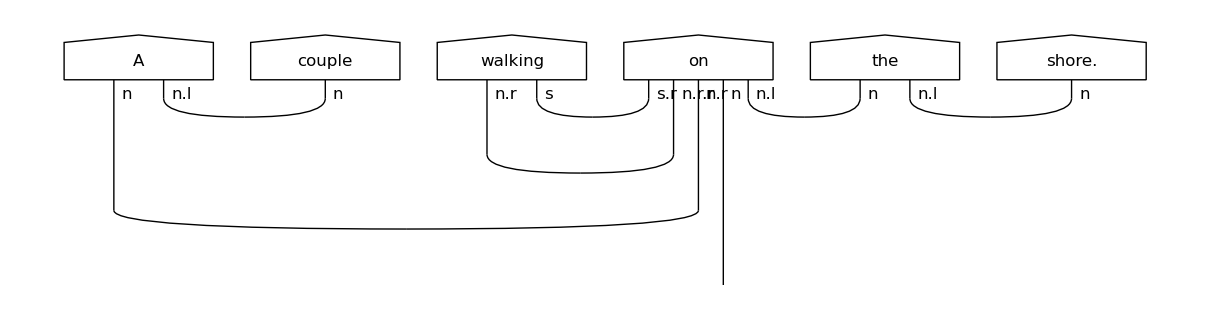

 creating diagrams ..
 ↓ sample sentence diagram without cups from train dataset


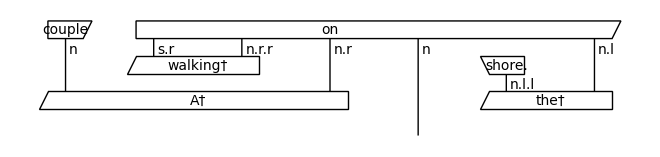

 ↓ sample sentence circuit from train dataset


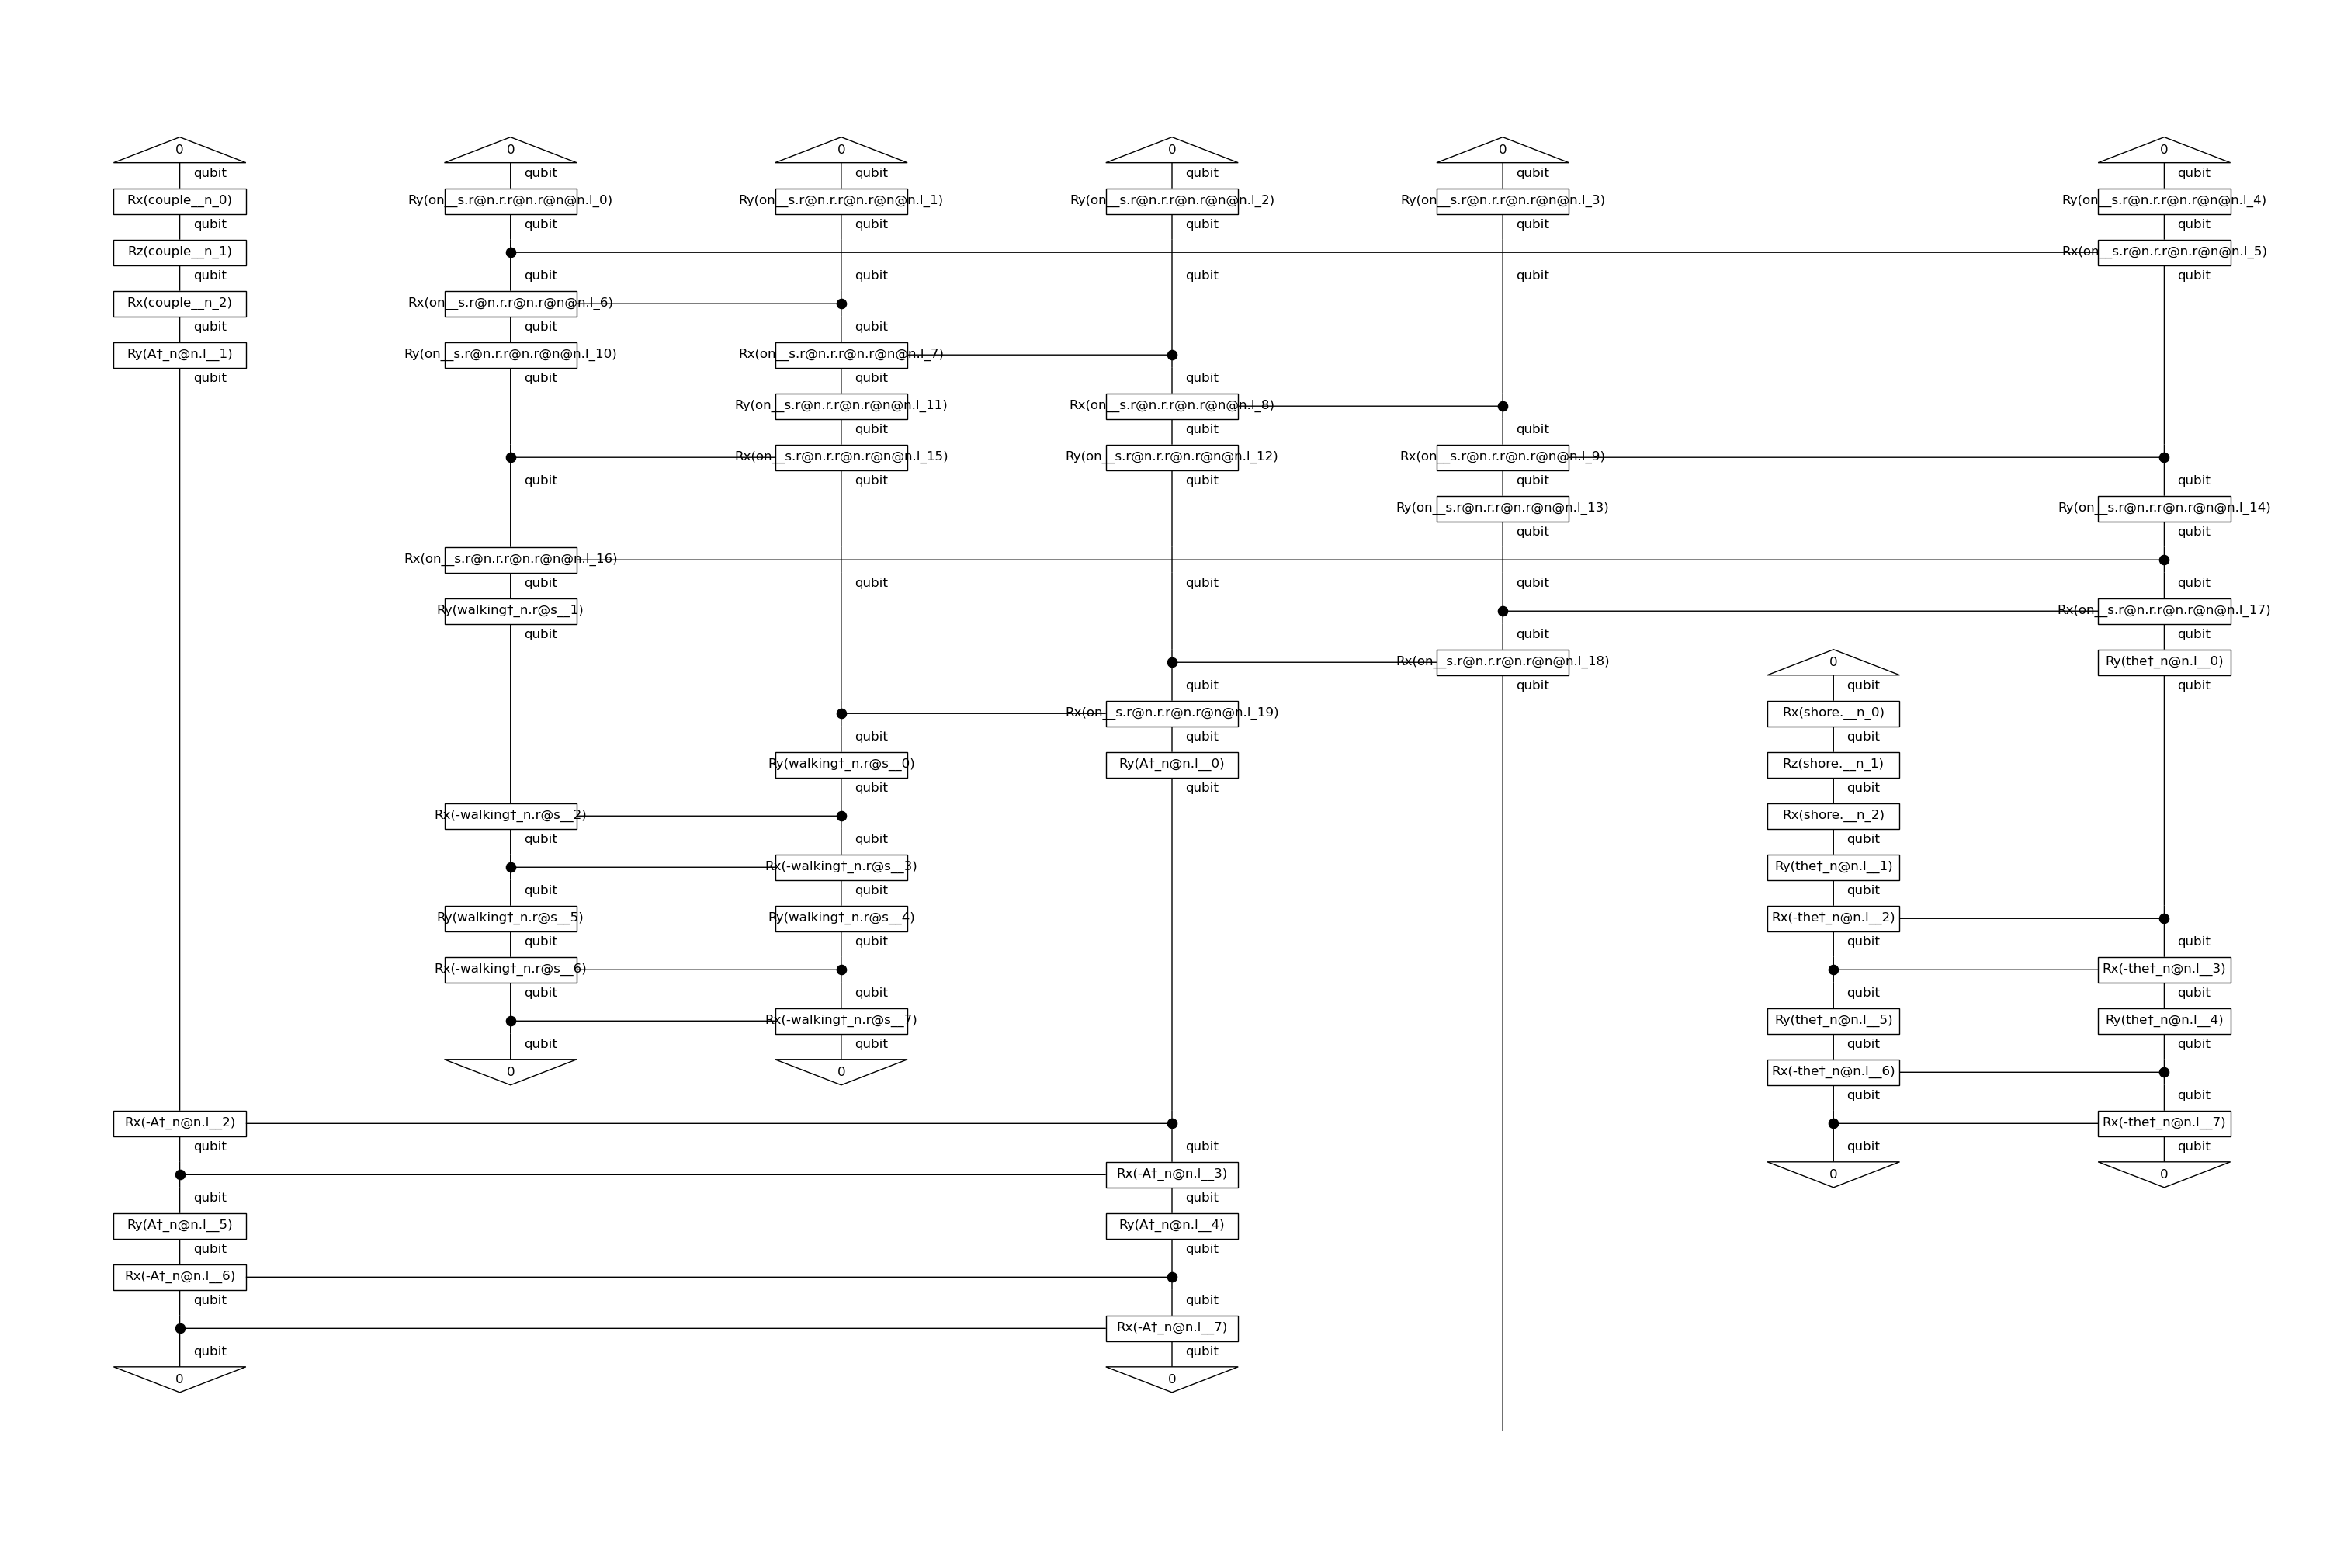

(*) Ansatz created for all senetnces!



In [200]:
# ==============================================
# CREATE SENTENCE DIAGRAMS
# ==============================================

remove_cups = RemoveCupsRewriter()

# Parse the sentence 
train_sentences = train_df["sentence"]
val_sentences = val_df["sentence"]
test_sentences = test_df["sentence"]

# Use BobbcatParser to convert it into a string diagram
print(" parsing sentences ..")
parser = BobcatParser(verbose='suppress')
raw_train_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in train_sentences]
raw_val_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in val_sentences]
raw_test_sentence_diagrams = [parser.sentence2diagram(sentence) for sentence in test_sentences]
# --------
print(" ↓ example senetnce diagram from train dataset")
raw_train_sentence_diagrams[1].draw(figsize=(14, 3), fontsize=12)
# --------

# Use remove cups to decrease the number of wires used
print(" creating diagrams ..")
train_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in raw_train_sentence_diagrams]
val_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in raw_val_sentence_diagrams]
test_diagrams_sentence = [remove_cups(sentence_diagram) for sentence_diagram in raw_test_sentence_diagrams]
# --------
print(' ↓ sample sentence diagram without cups from train dataset')
train_diagrams_sentence[1].draw()
# --------

ansatz_sentence = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1},n_layers=1)

train_circuits_sentence = [ansatz_sentence(diagram) for diagram in train_diagrams_sentence]
val_circuits_sentence = [ansatz_sentence(diagram) for diagram in val_diagrams_sentence]
test_circuits_sentence = [ansatz_sentence(diagram) for diagram in test_diagrams_sentence]
# --------
print(' ↓ sample sentence circuit from train dataset')
train_circuits_sentence[1].draw(figsize=(30, 20), fontsize=12)
# --------

print("(*) Ansatz created for all senetnces!\n")

## Image Diagram & Circuit

 Complete: circuits for positive image
 ↓ sample sentence diagram without cups from train dataset


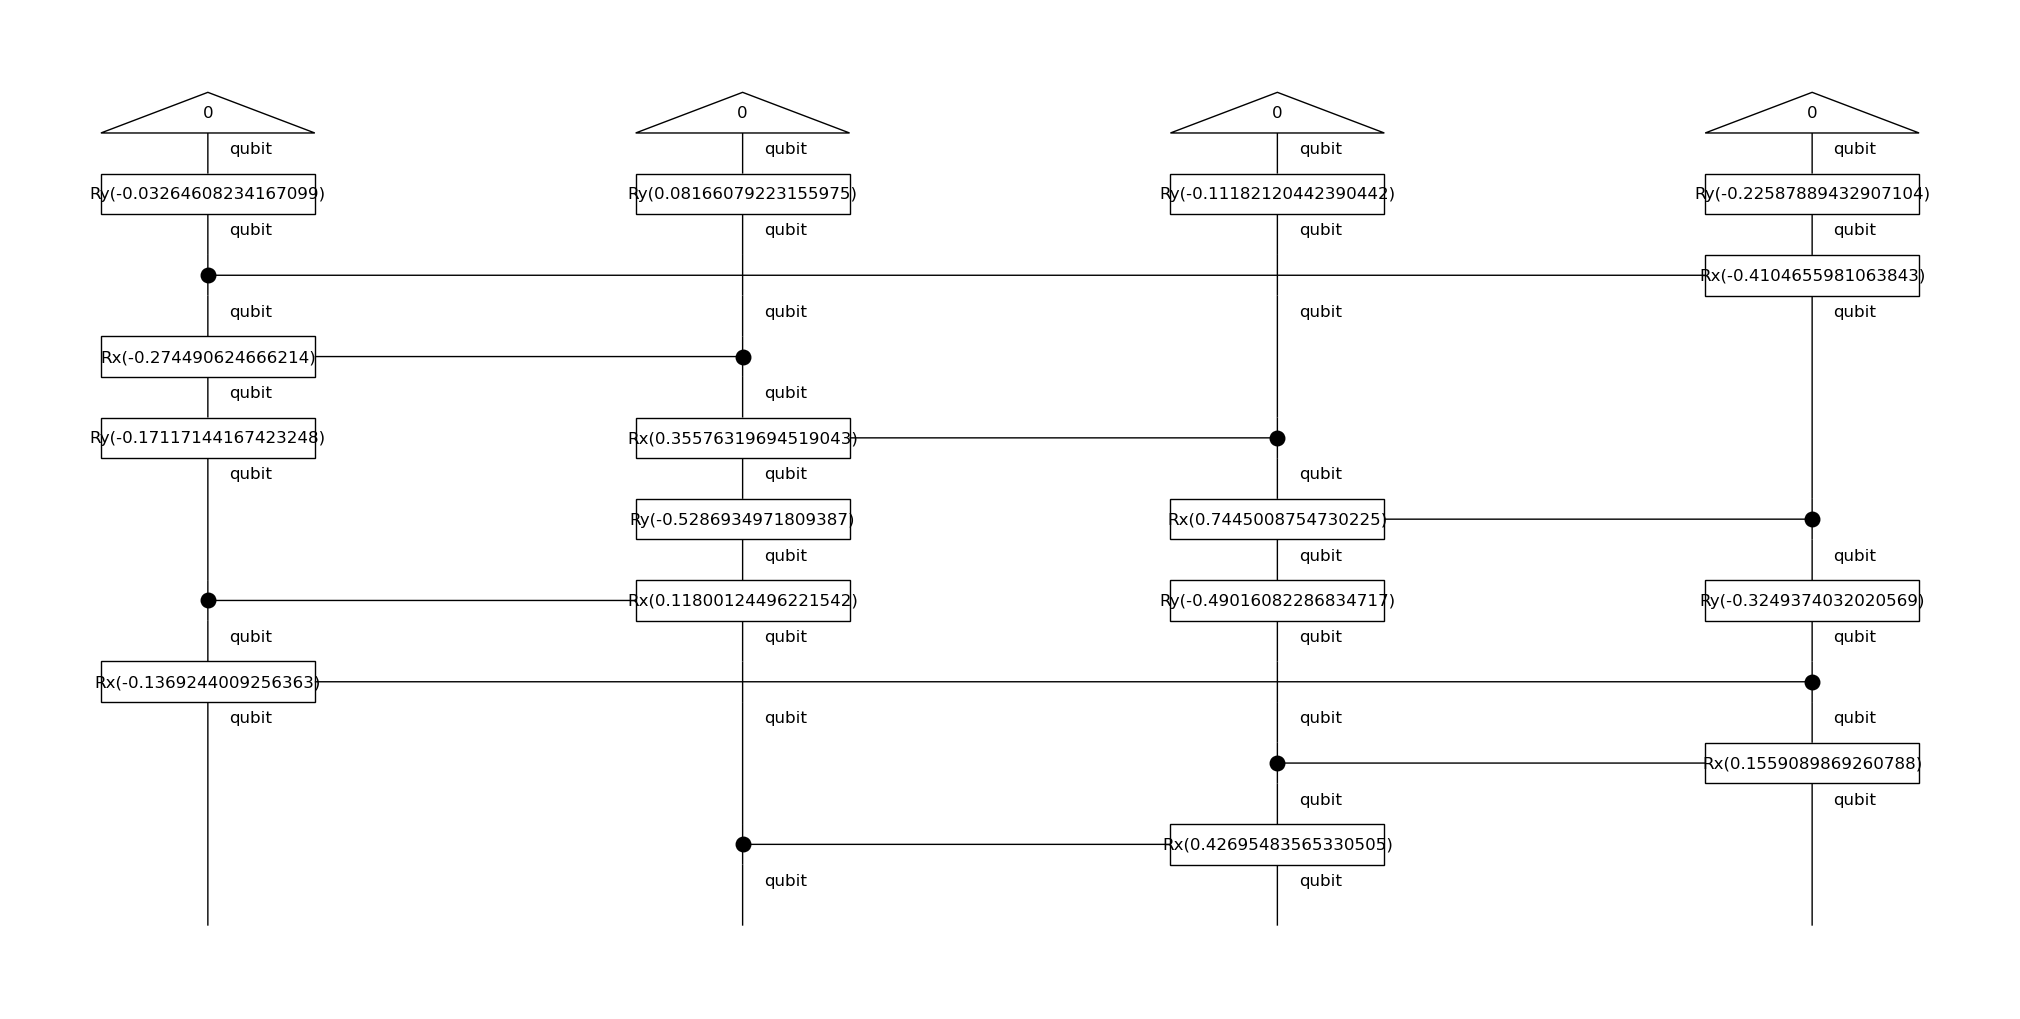

 Complete: circuit for negative images


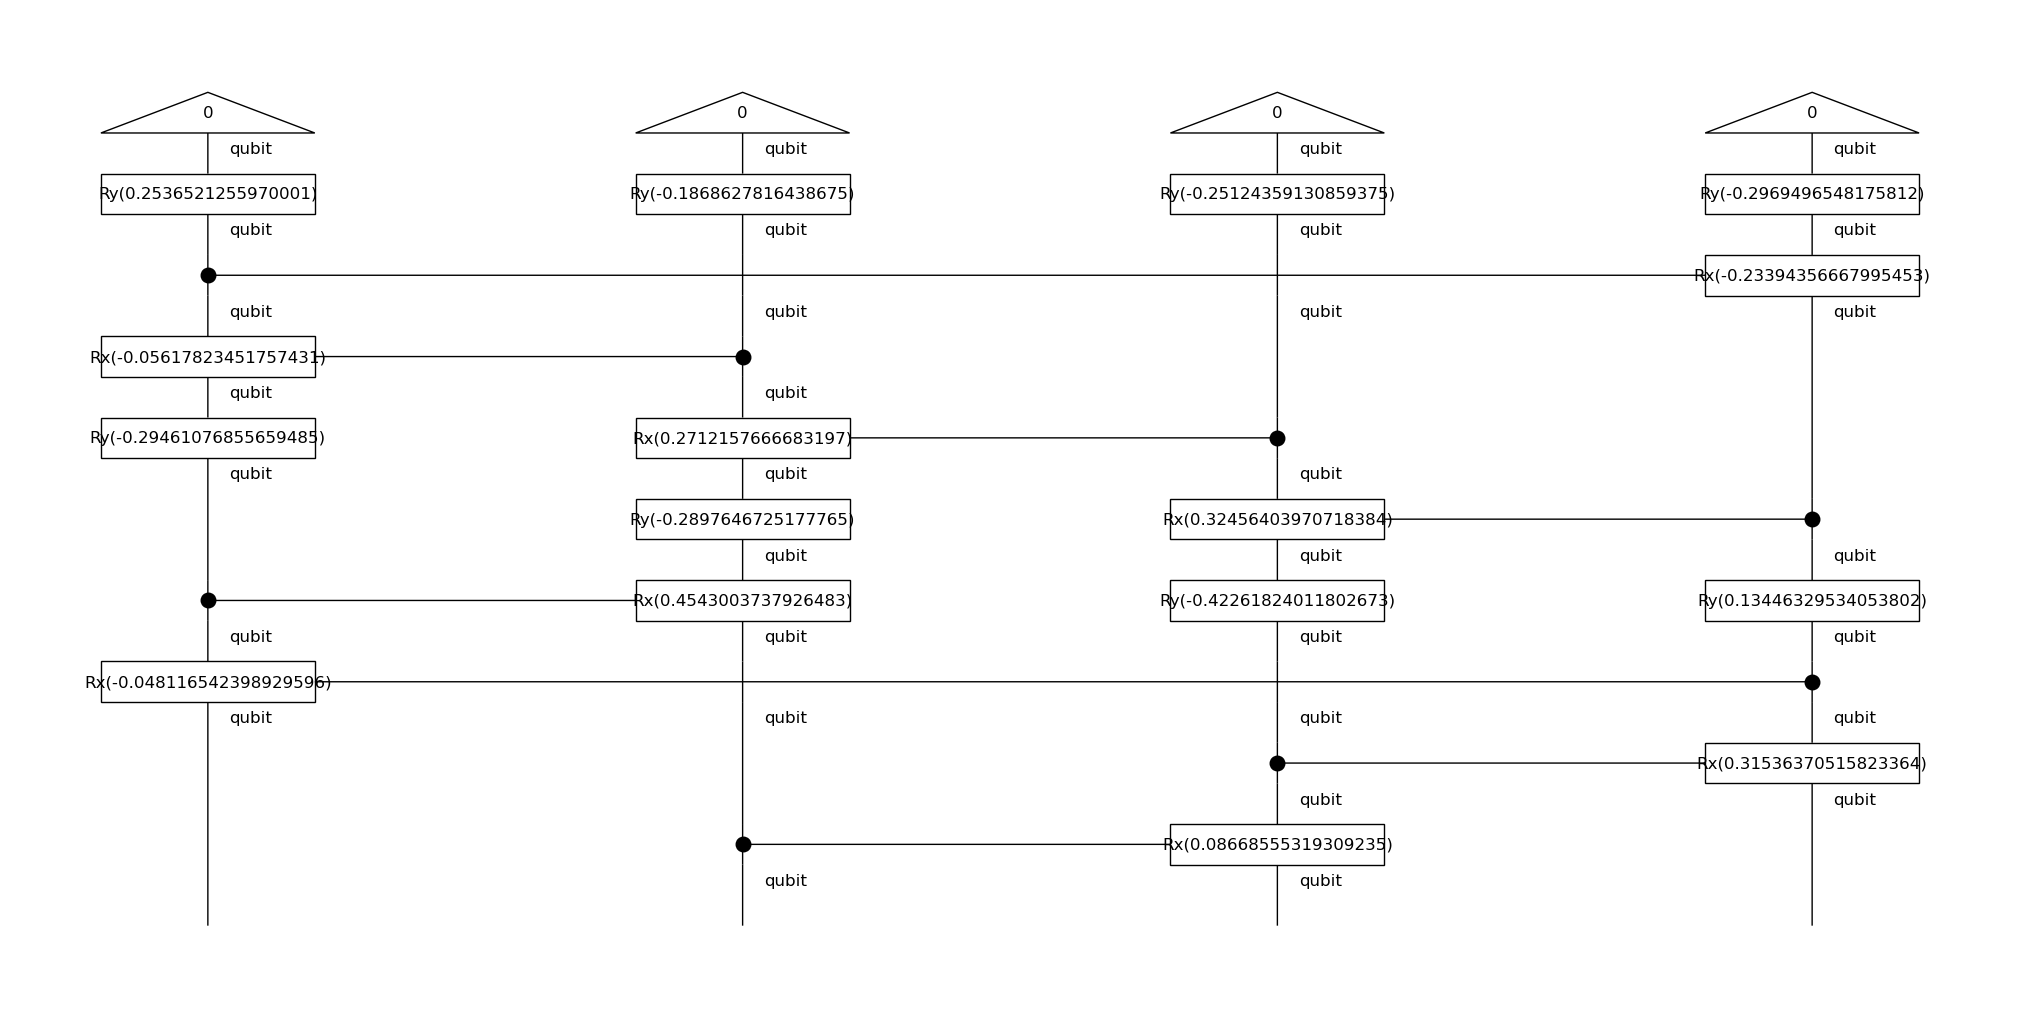

(*) Circuits and digrams created for all images!



In [201]:
# Create a new image Ty
image_type = Ty("image")
image_box = Box(name = "IMAGE", dom = Ty(), cod= image_type)
# image_box.draw(figsize=(14, 3), fontsize=12)

# Create template Ansatz
ansatz = Sim14Ansatz({image_type: 4}, n_layers=1)
image_circ = ansatz(image_box)
# print('↓ template image circuit')
# image_circ.draw(figsize=(20, 10), fontsize=12)

# Add data into image circuit POSITIVE
train_images_1 = train_df["image_1"]
val_images_1 = val_df["image_1"]
test_images_1 = test_df["image_1"]

train_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in train_images_1]
val_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in val_images_1]
test_circuits_image1 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in test_images_1]
print(" Complete: circuits for positive image")
#  --------
print(' ↓ sample sentence diagram without cups from train dataset')
train_circuits_image1[1].draw(figsize=(20, 10), fontsize=12)
#  --------

# Add data into image circuit NEGATIVE
train_images_2 = train_df["image_2"]
val_images_2 = val_df["image_2"]
test_images_2 = test_df["image_2"]

train_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in train_images_2]
val_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in val_images_2]
test_circuits_image2 = [image_circ.lambdify(*list(image_circ.free_symbols))(*feature_vec) for feature_vec in test_images_2]
print(" Complete: circuit for negative images")
#  --------
train_circuits_image2[1].draw(figsize=(20, 10), fontsize=12)
#  --------

print("(*) Circuits and digrams created for all images!\n")

## Combined for Sentence & Images:

WARNING:
- ONLY RUN THIS CODE ONCE!

#### Diagram template 

************************
Dropped the following indicies: [1, 15, 27, 45, 47, 54, 55, 56, 60, 63, 71, 76, 85, 88, 92, 107, 118, 130]
************************
Dropped the following indicies: [3, 11]
************************
Dropped the following indicies: []
CHCEKING:
    124 -> 124 == 124
    29 -> 29 == 29
    31 -> 31 == 31
 ↓ template merged diagram : (sentence, image1, image2)


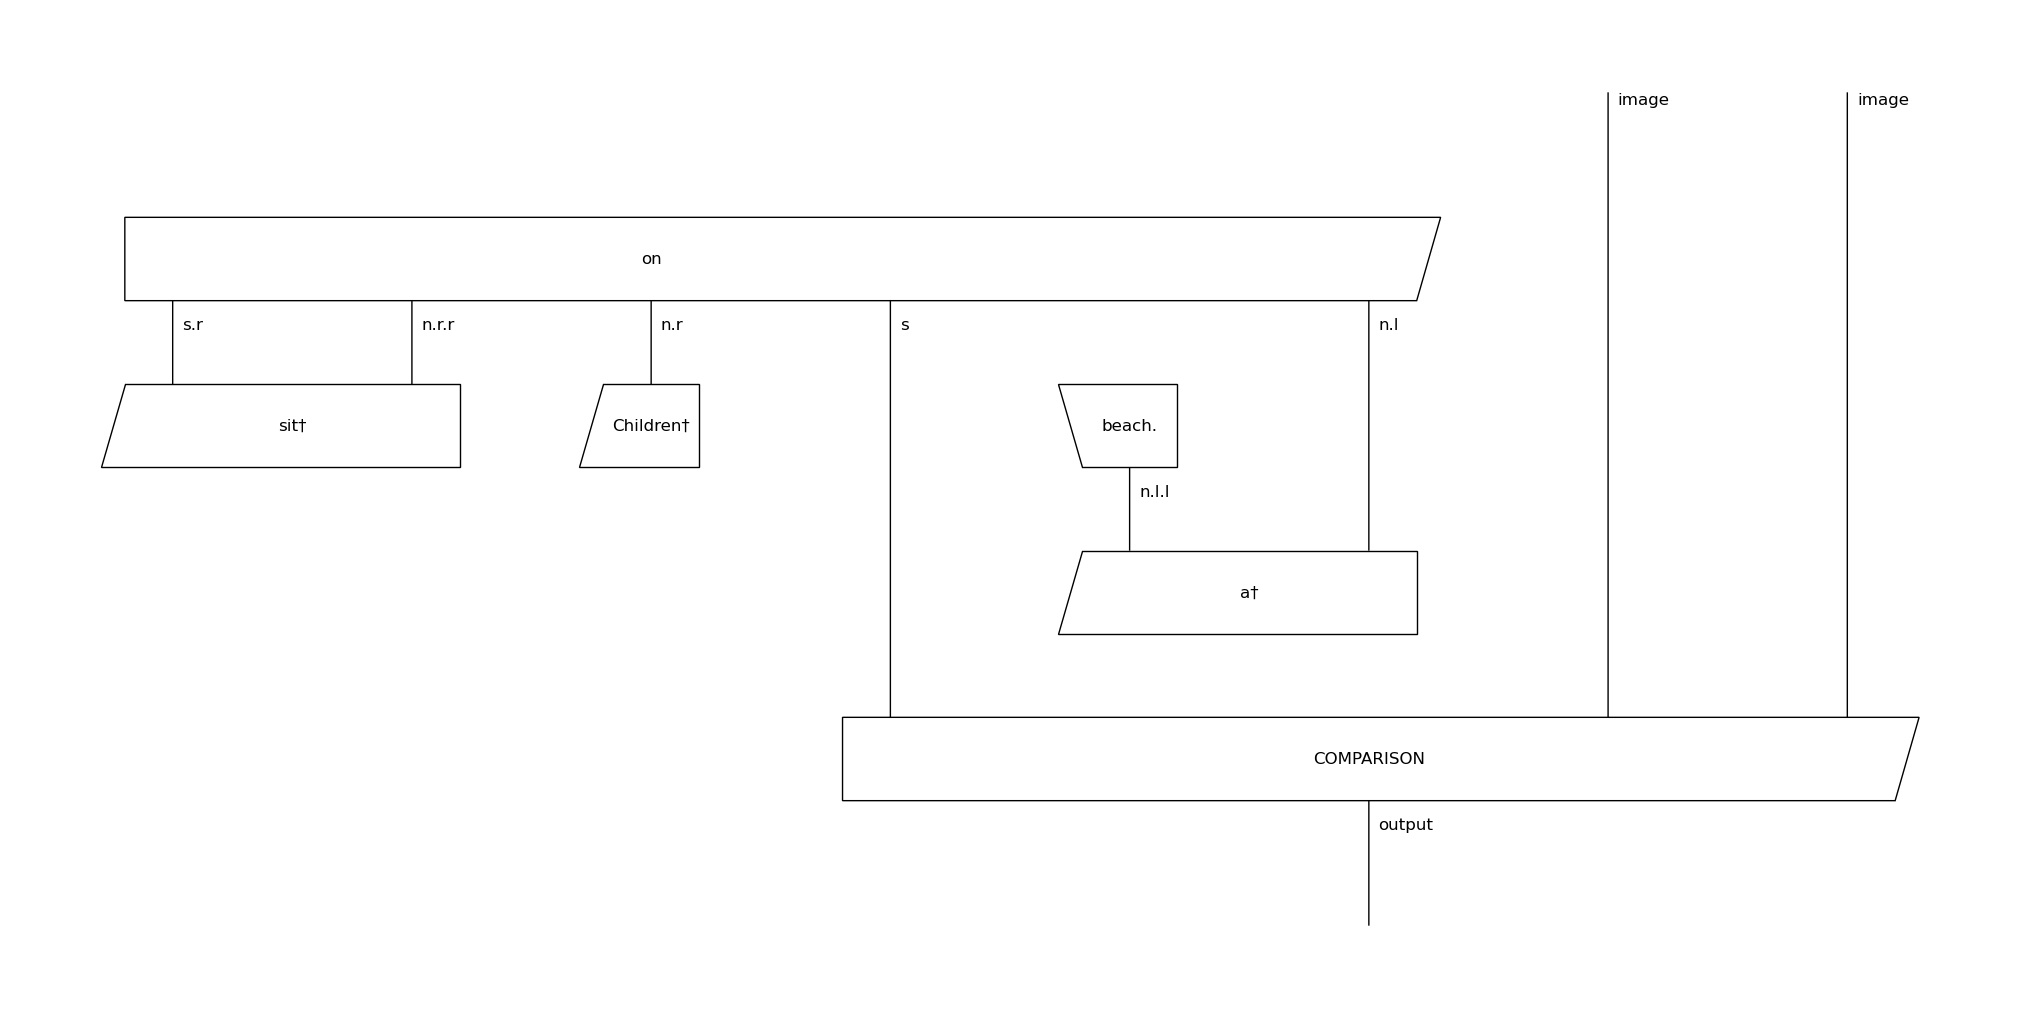



(*) Train: 124 diagrams completed successfully!
(*) Val: 29 diagrams completed successfully!
(*) Test: 31 diagrams completed successfully!


In [202]:
# CREATE FINAL CIRCUIT

def generate_valid_diagrams(diagram_sentence, df):
    print("************************")
    indicies_to_drop= []
    conc_diagrams = []
    for index, row in df.iterrows():
        try:
            temp = diagram_sentence[index] @ image_type @ image_type >> comparison_box
            conc_diagrams.append(temp)
        except Exception as e:
            # print(f"Error at index in diagram sentence {index}: {e}")
            # print( "    ",df["sentence"].iloc[index])
            indicies_to_drop.append(index)
    # print("************************")

    # print("************************")
    for index, row in df.iterrows():
        if index in indicies_to_drop:
            # print("Removing index: ", index)
            df = df.drop(index = index)
    # print("************************")

    print("Dropped the following indicies:", indicies_to_drop)
    
    return df, conc_diagrams

# Create new Type
output_type = Ty("output")
comparison_box = Box("COMPARISON", AtomicType.SENTENCE @ image_type @ image_type, output_type)

# Draws diagram with comparison box (0,1) - Sentence digram and comparison box is in grammar form

train_df, train_conc_diagrams = generate_valid_diagrams(train_diagrams_sentence, train_df)
val_df, val_conc_diagrams = generate_valid_diagrams(val_diagrams_sentence, val_df)
test_df, test_conc_diagrams = generate_valid_diagrams(test_diagrams_sentence, test_df)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("CHCEKING:")
print(f"    124 -> {len(train_df)} == {len(train_conc_diagrams)}")
print(f"    29 -> {len(val_df)} == {len(val_conc_diagrams)}")
print(f"    31 -> {len(test_df)} == {len(test_conc_diagrams)}")

print(' ↓ template merged diagram : (sentence, image1, image2)')
train_conc_diagrams[15].draw(figsize=(20, 10), fontsize=12)

print("")
print(f"\n(*) Train: {len(train_conc_diagrams)} diagrams completed successfully!")
print(f"(*) Val: {len(val_conc_diagrams)} diagrams completed successfully!")
print(f"(*) Test: {len(test_conc_diagrams)} diagrams completed successfully!")

#### Circuit Template

************************
Error at index in diagram sentence 0: Ty(p)
Error at index in diagram sentence 6: Ty(p)
Error at index in diagram sentence 27: Ty(p)
Error at index in diagram sentence 97: Ty(p)
Error at index in diagram sentence 99: Ty(p)
Error at index in diagram sentence 106: Ty(p)
Dropped the following indicies: [0, 6, 27, 97, 99, 106]
************************
Error at index in diagram sentence 7: Ty(p)
Error at index in diagram sentence 28: Ty(p)
Dropped the following indicies: [7, 28]
************************
Error at index in diagram sentence 18: Ty(p)
Dropped the following indicies: [18]
CHCEKING:
  (118) 118 == 118
  (27)  27 == 27
  (30)  30 == 30
 ↓ template merged circuit : (sentence, image1, image2)


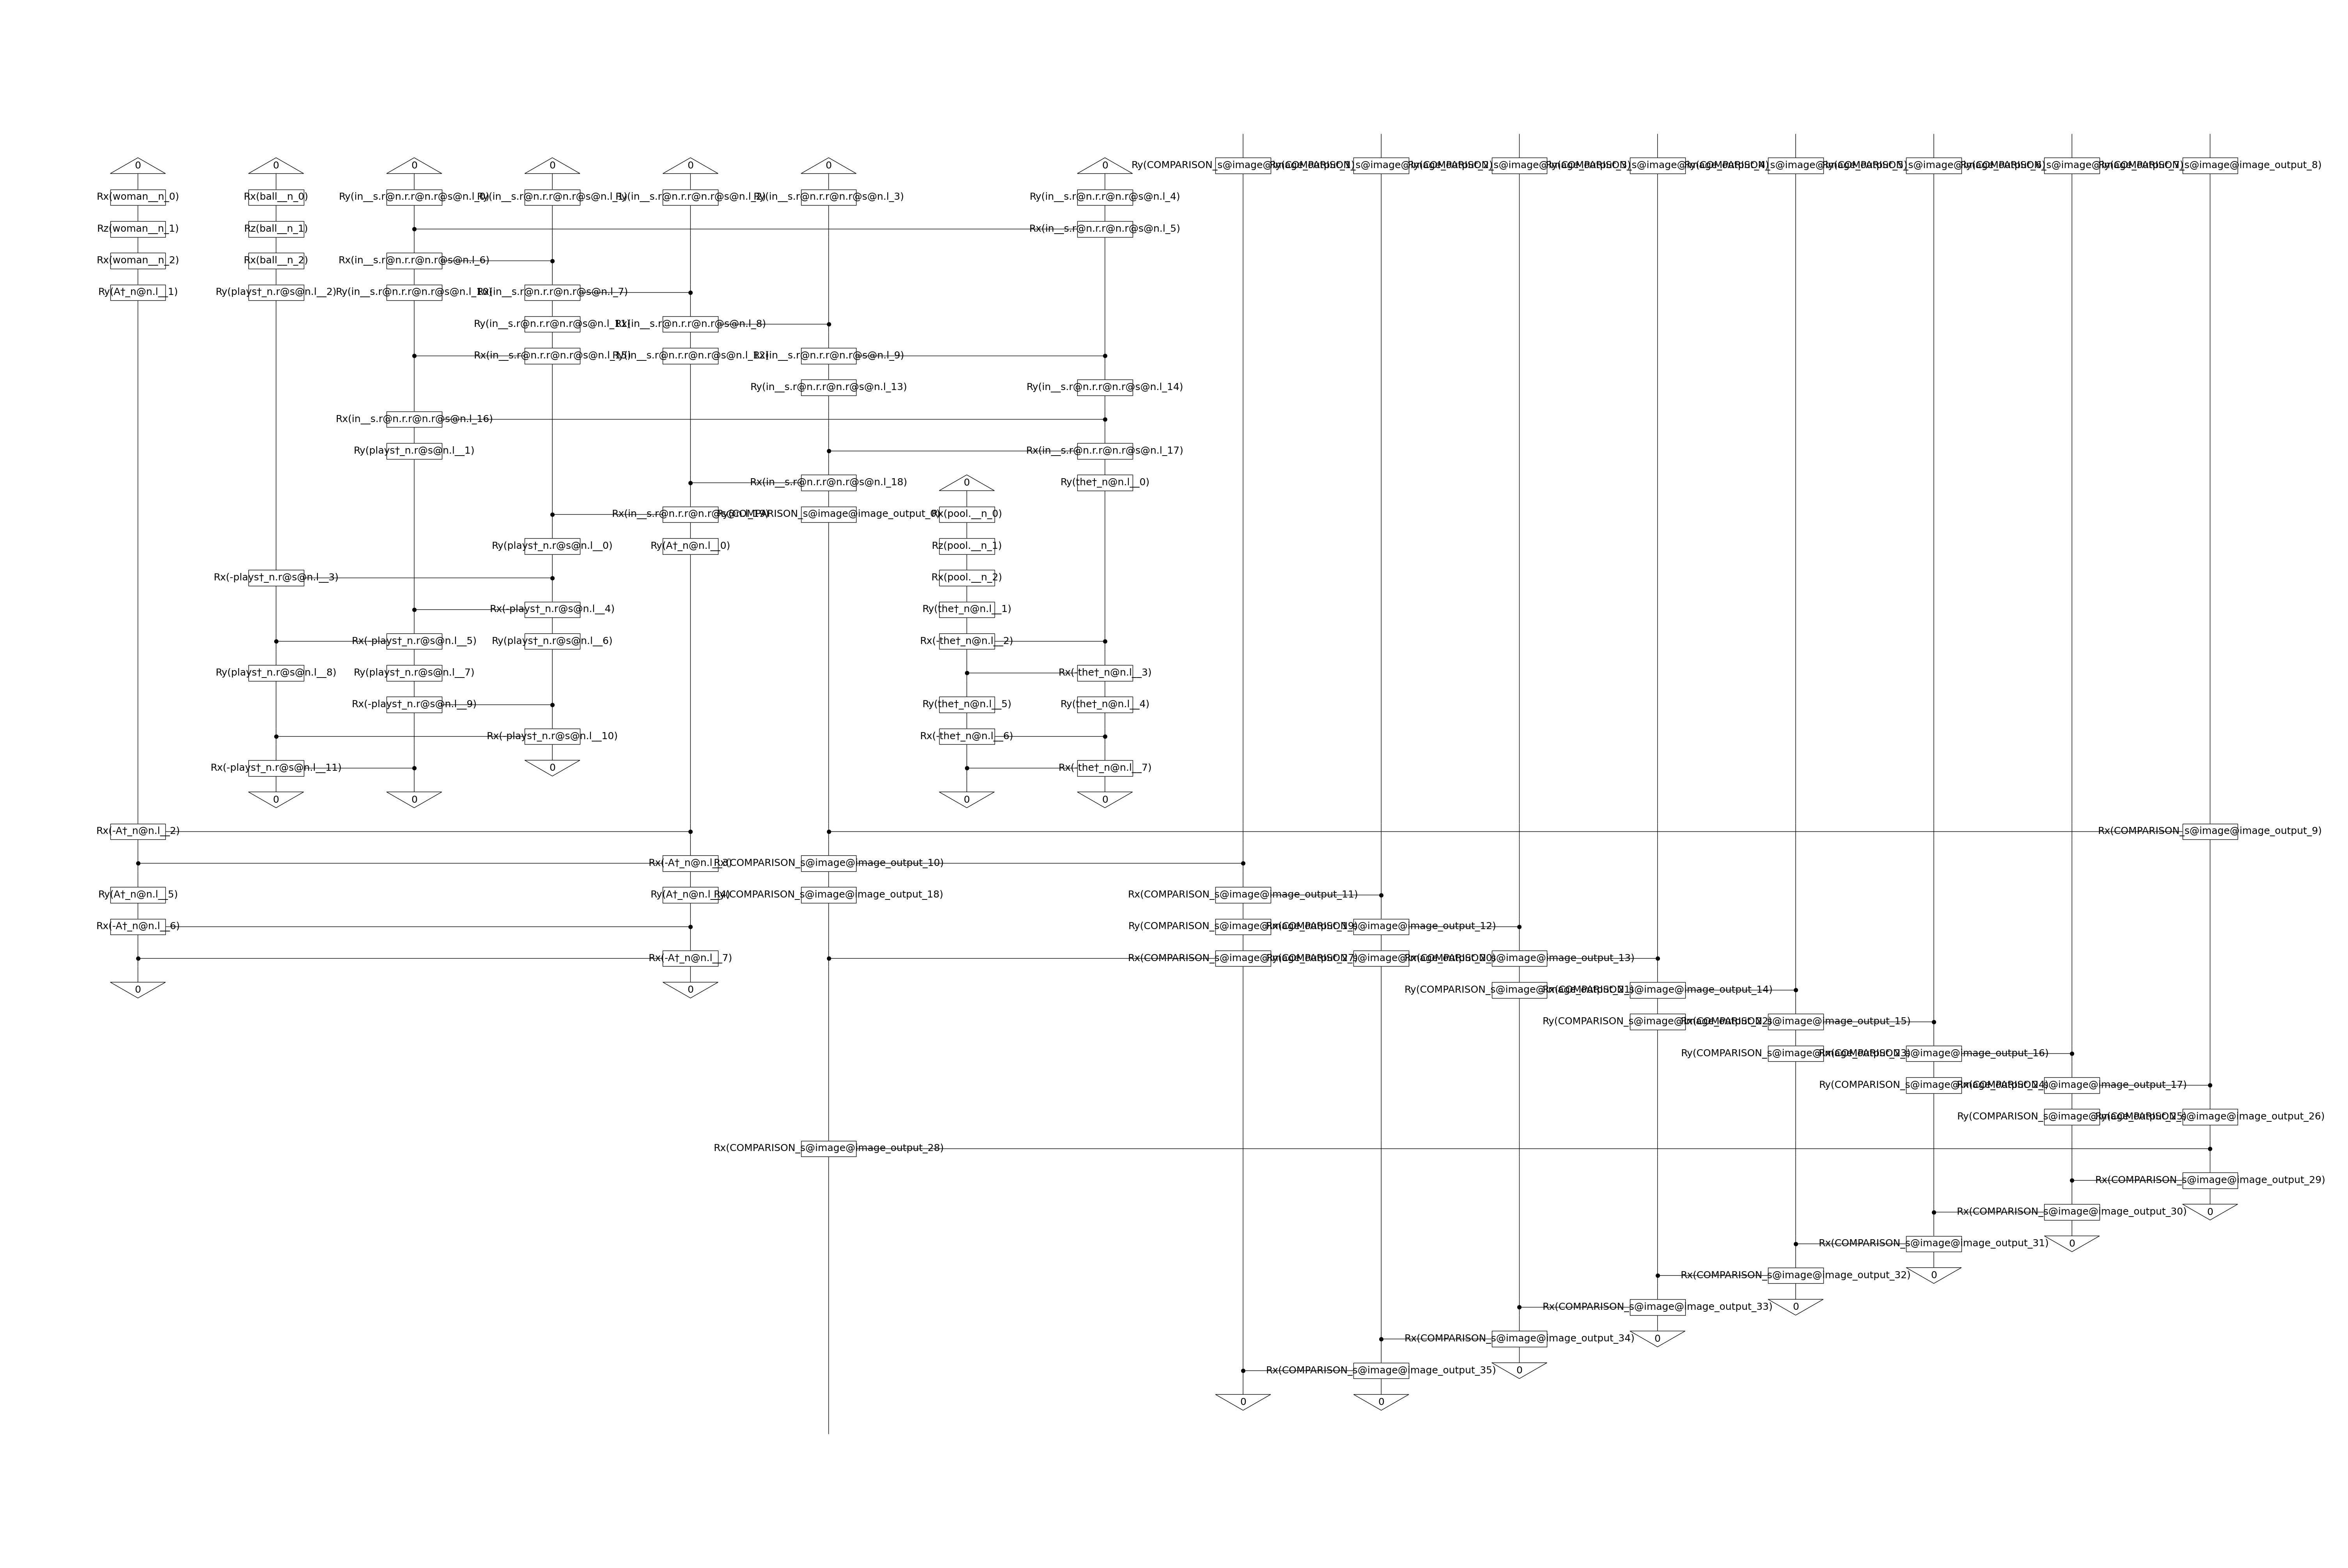



(*) Train: 118 circuits completed successfully!
(*) Val: 27 circuits completed successfully!
(*) Test: 30 circuits completed successfully!


In [203]:
# Ansatz & Circuit
ansatz = Sim14Ansatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, image_type : 4, output_type : 1},  n_layers=1)

# Incorrect prepositional phrases found in the diagrams
def generate_valid_circuits(conc_diagrams, df):
    print("************************")
    indicies_to_drop = []
    conc_circuit = []
    for index, row in df.iterrows():
        try:
            temp = ansatz(conc_diagrams[index])
            conc_circuit.append(temp)
        except Exception as e:
            print(f"Error at index in diagram sentence {index}: {e}")
            # print( "    ",df["sentence"].iloc[index])
            indicies_to_drop.append(index)
    # print("************************")

    # print("************************")
    for index, row in df.iterrows():
        if index in indicies_to_drop:
            # print("Removing index: ", index)
            df = df.drop(index = index)
    # print("************************")

    print("Dropped the following indicies:", indicies_to_drop)
    
    return df, conc_circuit

train_df, train_conc_circuits = generate_valid_circuits(train_conc_diagrams, train_df)
val_df, val_conc_circuits = generate_valid_circuits(val_conc_diagrams, val_df)
test_df, test_conc_circuits = generate_valid_circuits(test_conc_diagrams, test_df)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("CHCEKING:")
print(f"  (118) {len(train_df)} == {len(train_conc_circuits)}")
print(f"  (27)  {len(val_df)} == {len(val_conc_circuits)}")
print(f"  (30)  {len(test_df)} == {len(test_conc_circuits)}")

print(' ↓ template merged circuit : (sentence, image1, image2)')
train_conc_circuits[15].draw(figsize=(60, 40), fontsize=18, draw_type_labels = False )

print("")
print(f"\n(*) Train: {len(train_conc_circuits)} circuits completed successfully!")
print(f"(*) Val: {len(val_conc_circuits)} circuits completed successfully!")
print(f"(*) Test: {len(test_conc_circuits)} circuits completed successfully!")


#### Final Circuit 

  ↓ sample quantum circuit : (sentence, image data pos , image data neg)


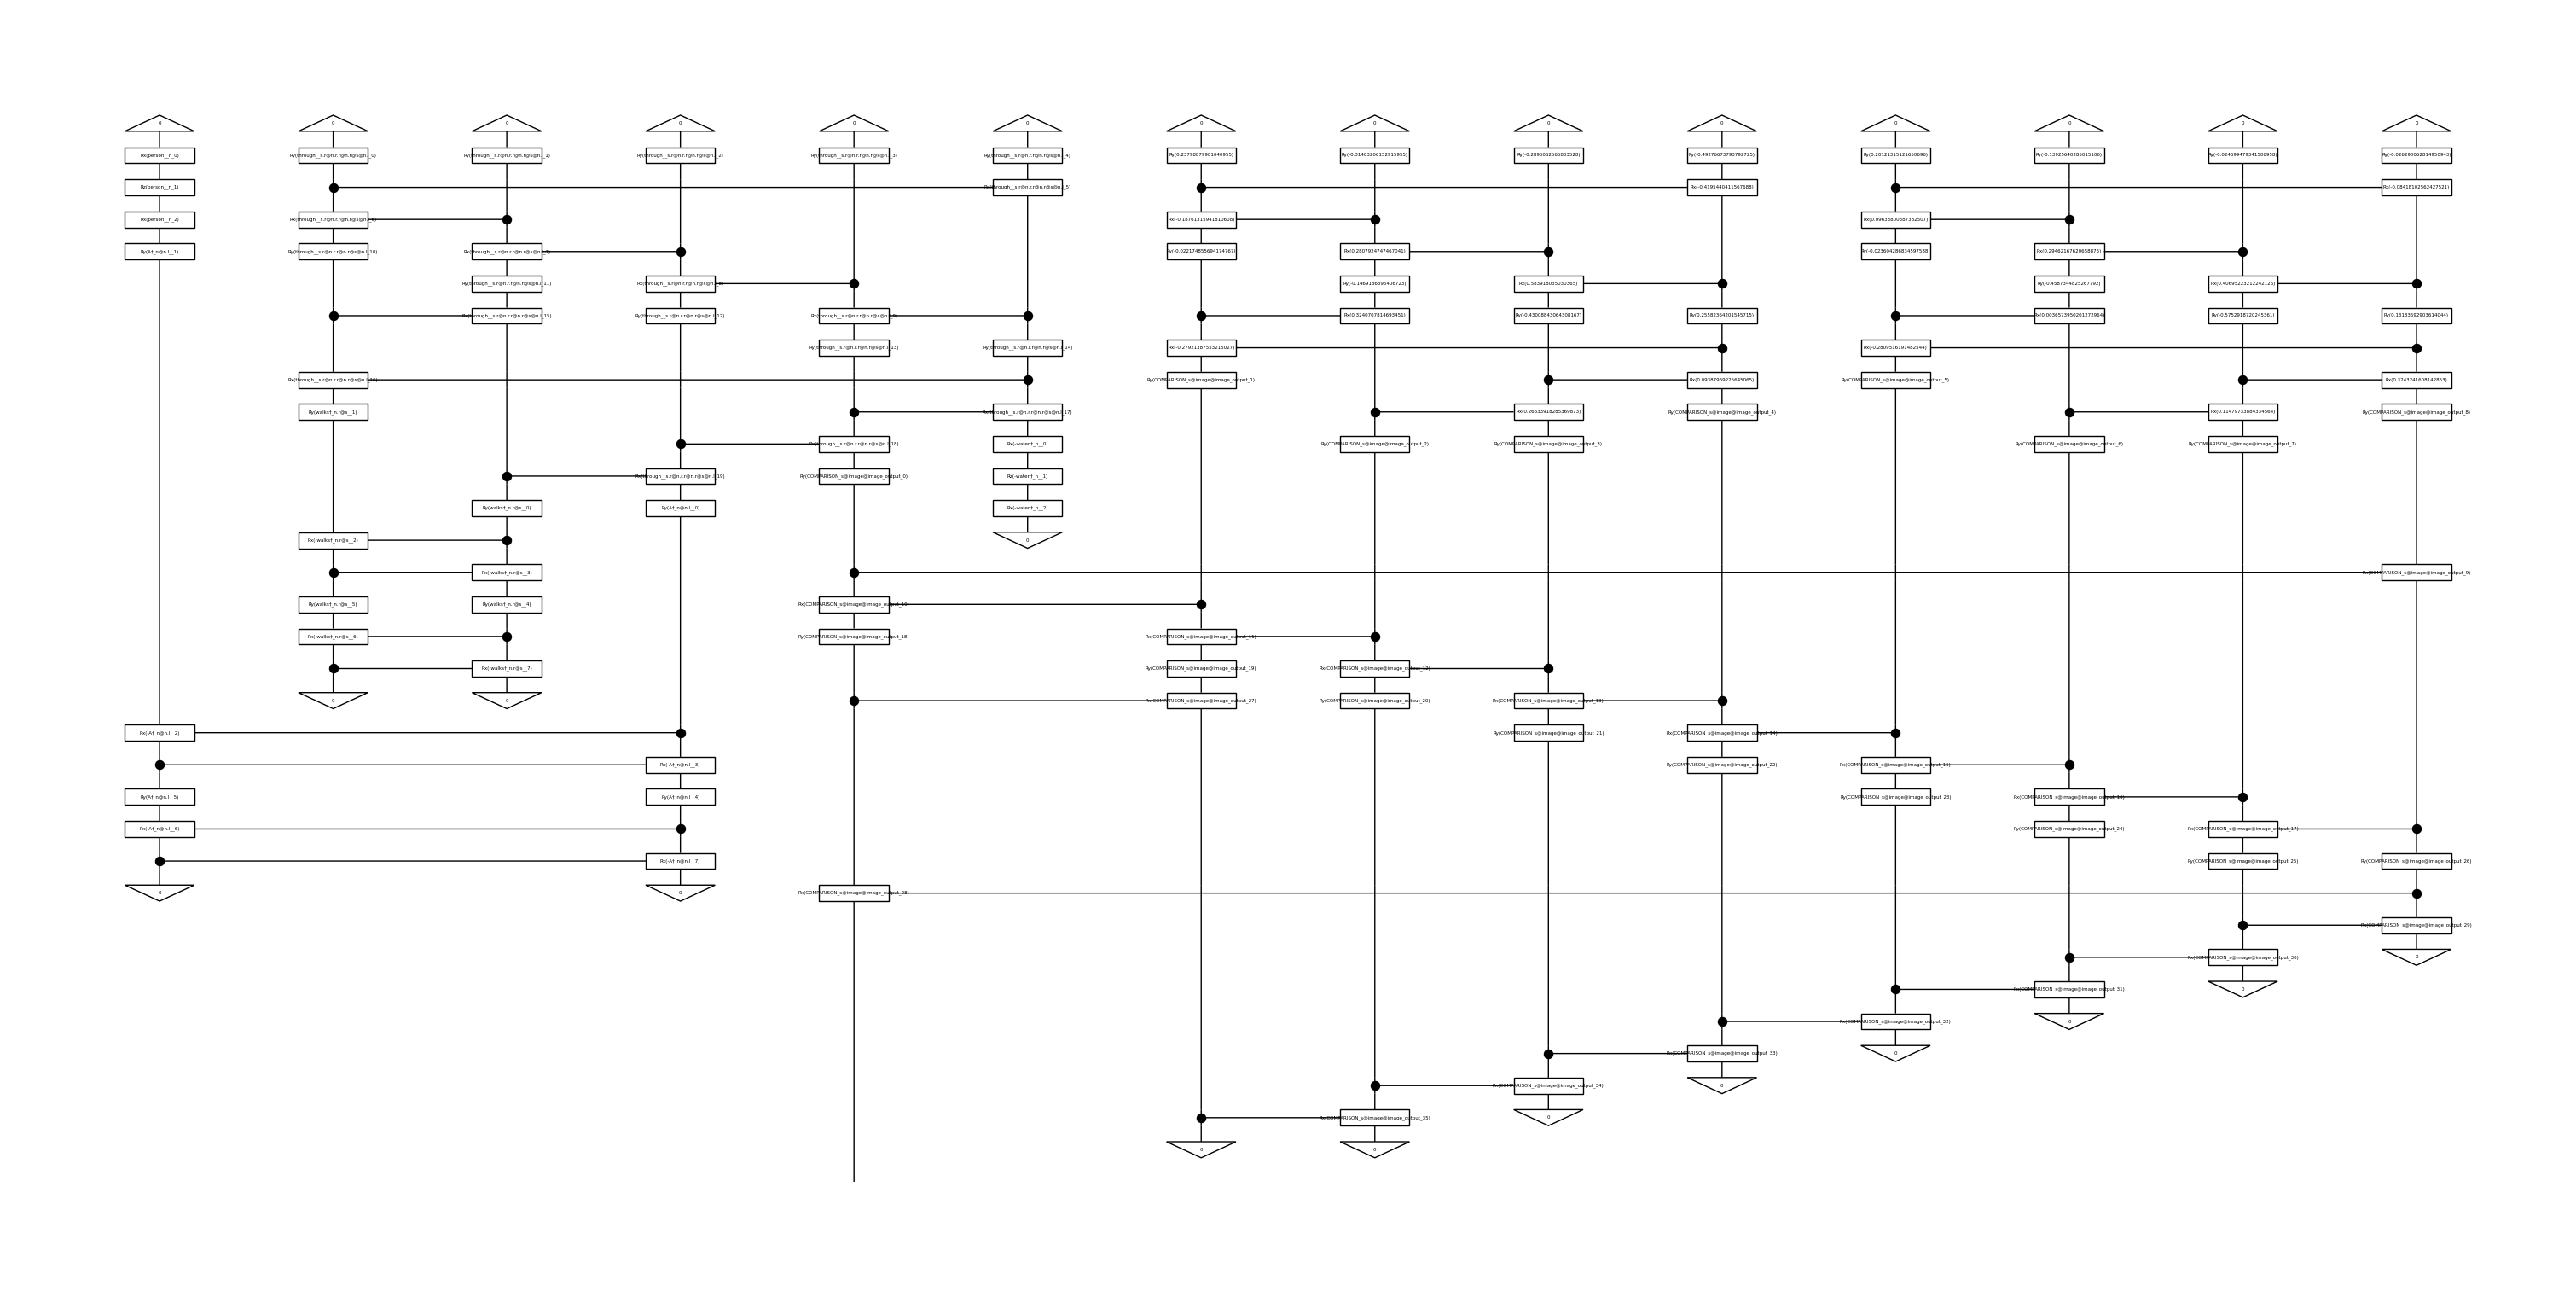


(*) Train: 118 circuits completed successfully!
(*) Val:27 circuits completed successfully!
(*) Test: 30 circuits completed successfully!


In [204]:
# final_circuit = image_1 @ image_2 >> temp_circuit

train_final_circuit = [(train_circuits_image1[index] @ train_circuits_image2[index] >> train_conc_circuits[index]) for index in range(len(train_df))]
val_final_circuit = [(val_circuits_image1[index] @ val_circuits_image2[index] >> val_conc_circuits[index]) for index in range(len(val_df))]
test_final_circuit = [(test_circuits_image1[index] @ test_circuits_image2[index] >> test_conc_circuits[index]) for index in range(len(test_df))]

print("  ↓ sample quantum circuit : (sentence, image data pos , image data neg)")
train_final_circuit[0].draw(figsize=(30, 15), fontsize=4, draw_type_labels = False )

print(f"\n(*) Train: {len(train_final_circuit)} circuits completed successfully!")
print(f"(*) Val:{len(val_final_circuit)} circuits completed successfully!")
print(f"(*) Test: {len(test_final_circuit)} circuits completed successfully!")


adding a labels row

-> SHOUDL MOVE THIS TO DATASET SECTION

In [216]:
train_df['labels'] = train_df.apply(lambda row: (row['label_image1'], row['label_image2']), axis=1)
val_df['labels'] = val_df.apply(lambda row: (row['label_image1'], row['label_image2']), axis=1)
test_df['labels'] = test_df.apply(lambda row: (row['label_image1'], row['label_image2']), axis=1)


## Training on Quantum Circuit

this is taken from [7] onwords https://cqcl.github.io/lambeq/examples/quantum-pipeline-jax.html 

In [300]:
# Define a custom loss function that handles multi-output
def custom_loss(y_hat, y):
    # Reshape y to match y_hat  
    y = y.squeeze(axis=1)

    print("Loss function")

    # print(f"y_hat shape: {y_hat.shape}, y shape: {y.shape}")
    # print(f"y1 = {y_hat}, y2 = {y}")

    loss = BinaryCrossEntropyLoss(use_jax=True)(y_hat, y)
    return loss

# Custom accuracy function for multi-output
def custom_acc(y_hat, y):
    # Rounding predictions to nearest integer to get binary predictions
    y_hat_rounded = np.round(y_hat)
    
    # Calculate accuracy for each output separately
    correct_predictions = (y_hat_rounded == y)
    accuracy_per_output = np.mean(correct_predictions, axis=0)
    
    # Average accuracy across both outputs
    mean_accuracy = np.mean(accuracy_per_output)
    
    return mean_accuracy


In [309]:
# Create a model 
from lambeq import NumpyModel
from lambeq import BinaryCrossEntropyLoss
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset
import jax

print("Variables")
BATCH_SIZE = 30
LEARNING_RATE = 3e-2
EPOCHS = 800
SEED = 0

print("Definitions")
# Labels
train_labels = np.array([[label] for label in train_df['labels']]).squeeze(axis=1)
val_labels = np.array([[label] for label in val_df['labels']]).squeeze(axis=1)
test_labels = np.array([[label] for label in test_df['labels']]).squeeze(axis=1)

# Circuits
all_circuits = train_final_circuit + val_final_circuit + test_final_circuit

print("Model")
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
bce = BinaryCrossEntropyLoss(use_jax=True)
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting


print("Initialize the trainer")
trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

print("Dataset")
train_dataset = Dataset(train_final_circuit, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(val_final_circuit, val_labels, shuffle=False)

Variables
Definitions
Model
Initialize the trainer
Dataset


In [310]:
trainer.fit(train_dataset, val_dataset, log_interval=50)

2024-07-28 19:08:10.733567: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m44.704066s

********************************
[Compiling module jit_diagram_output] Slow compile? XLA was built without compiler optimizations, which can be slow. Try rebuilding with -c opt.
********************************
Epoch 50:   train/loss: 0.9975   valid/loss: 1.1765   train/acc: 0.4703   valid/acc: 0.3704
Epoch 100:  train/loss: 0.9101   valid/loss: 0.7692   train/acc: 0.5254   valid/acc: 0.5556
Epoch 150:  train/loss: 0.7227   valid/loss: 0.6007   train/acc: 0.5551   valid/acc: 0.6296
Epoch 200:  train/loss: 1.1419   valid/loss: 0.8204   train/acc: 0.4322   valid/acc: 0.5926
Epoch 250:  train/loss: 0.8620   valid/loss: 0.8530   train/acc: 0.6314   valid/acc: 0.5926
Epoch 300:  train/loss: 0.6167   valid/loss: 0.8658   train/acc: 0.6398   valid/acc: 0.5185
Epoch 350:  train/loss: 0.6994   valid/loss: 1.4186   train/acc: 0.5932   valid/acc: 0.3704
Epoch 400:  train/loss: 0.70

Test accuracy: 0.5


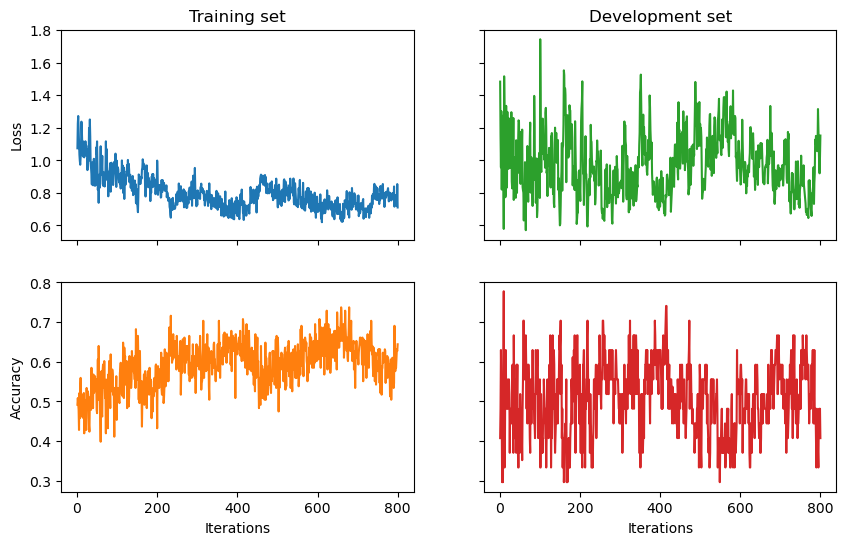

In [311]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

test_acc = acc(model(test_final_circuit), np.array(test_labels))
print('Test accuracy:', test_acc)

## Scratch Paper

EXCERSIZE: sample output

In [270]:
# Prepare the sample input
sample_input = train_final_circuit[0:1]  # Assuming train_final_circuit contains circuits

# Get the model output by calling the model with the sample input
sample_output = model(sample_input)

# Print the shape of the output
print(f"Sample output: {sample_output}")
print(f"Sample output shape: {sample_output.shape}")



Sample output: [[0.04946537 0.95053464]]
Sample output shape: (1, 2)
